<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Simple_Implementation_of_PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Physics-Informed Neural Networks (PINNs) are a type of neural network that leverages both data and physical laws (represented by differential equations) to model complex systems. They are particularly useful for solving partial differential equations (PDEs), where traditional numerical methods may be computationally expensive or infeasible. PINNs incorporate these physical laws as part of the loss function, allowing the network to not only fit data but also adhere to the governing physics.

# Steps to Solve the Poisson Equation Using PINNs
1. Define the Neural Network: A fully connected neural network is used to approximate the solution 𝑢(𝑥,𝑦) of the Poisson equation.
2. Formulate the PDE Residual: The residual of the Poisson equation is derived by substituting the network's output into the equation.
3. Define the Loss Function: The loss function consists of two parts:
- PDE Loss: Ensures that the network's output satisfies the Poisson equation.
- Boundary Condition Loss: Ensures that the network satisfies the boundary conditions.
4. Train the Network: The network is trained by minimizing the combined loss.


In [10]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Generate Training Data and Visualize


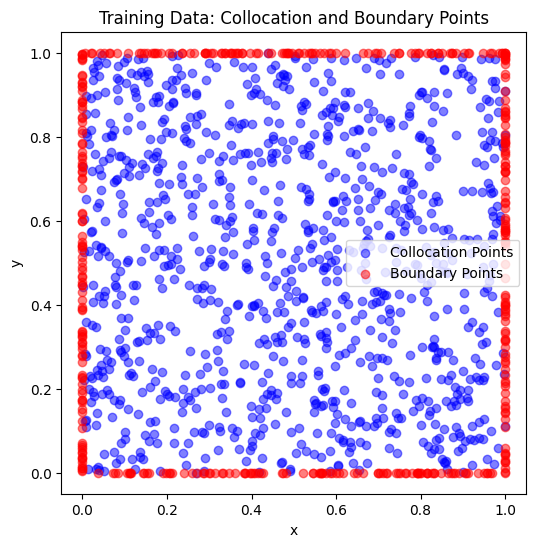

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def generate_training_data(N_collocation, N_boundary):
    # Collocation points inside the domain [0, 1] x [0, 1]
    X_collocation = np.random.rand(N_collocation, 2)

    # Boundary points (sides of the square domain)
    X_boundary = np.vstack([
        np.hstack([np.random.rand(N_boundary, 1), np.zeros((N_boundary, 1))]),     # Bottom edge y=0
        np.hstack([np.zeros((N_boundary, 1)), np.random.rand(N_boundary, 1)]),     # Left edge x=0
        np.hstack([np.ones((N_boundary, 1)), np.random.rand(N_boundary, 1)]),      # Right edge x=1
        np.hstack([np.random.rand(N_boundary, 1), np.ones((N_boundary, 1))])       # Top edge y=1
    ])

    return X_collocation, X_boundary

# Generate data
N_collocation = 1000  # For quicker visualization, we'll use 1000 points
N_boundary = 100
X_collocation, X_boundary = generate_training_data(N_collocation, N_boundary)

# Plot the collocation and boundary points
plt.figure(figsize=(6, 6))
plt.scatter(X_collocation[:, 0], X_collocation[:, 1], color='blue', label='Collocation Points', alpha=0.5)
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], color='red', label='Boundary Points', alpha=0.5)
plt.title('Training Data: Collocation and Boundary Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Step 2: Initialize and Train the Model with Intermediate Outputs


Epoch 0, Loss: 92.657958984375
Epoch 10, Loss: 85.78732299804688
Epoch 20, Loss: 77.43045806884766
Epoch 30, Loss: 67.2212142944336
Epoch 40, Loss: 55.23981475830078
Epoch 50, Loss: 41.87286376953125
Epoch 60, Loss: 29.627859115600586
Epoch 70, Loss: 22.53960609436035
Epoch 80, Loss: 18.82715606689453
Epoch 90, Loss: 14.933073997497559
Epoch 100, Loss: 12.194108009338379
Epoch 110, Loss: 11.234859466552734
Epoch 120, Loss: 10.49251937866211
Epoch 130, Loss: 9.761491775512695
Epoch 140, Loss: 9.098204612731934
Epoch 150, Loss: 8.446521759033203
Epoch 160, Loss: 7.79474401473999
Epoch 170, Loss: 7.1581315994262695
Epoch 180, Loss: 6.553475379943848
Epoch 190, Loss: 5.998991012573242
Epoch 200, Loss: 5.501282215118408
Epoch 210, Loss: 5.047455787658691
Epoch 220, Loss: 4.614601135253906
Epoch 230, Loss: 4.186364650726318
Epoch 240, Loss: 3.757883071899414
Epoch 250, Loss: 3.3326196670532227
Epoch 260, Loss: 2.9202880859375
Epoch 270, Loss: 2.534946918487549
Epoch 280, Loss: 2.190609931945

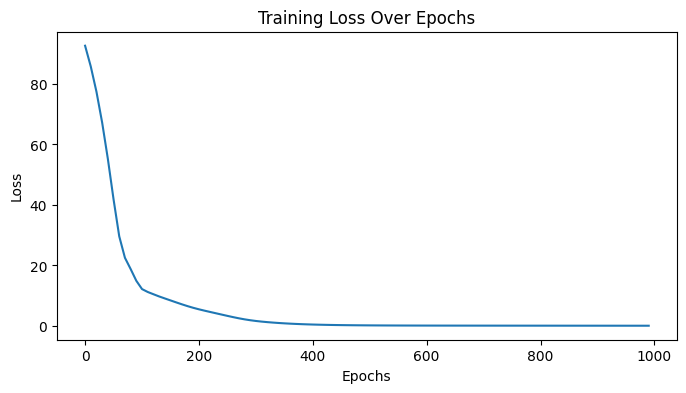

In [14]:
import tensorflow as tf

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)

    def call(self, X):
        x = self.dense1(X)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

def pde_loss(model, X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        u = model(X)
        u_x = tape.gradient(u, X)[:, 0:1]
        u_y = tape.gradient(u, X)[:, 1:2]
        u_xx = tape.gradient(u_x, X)[:, 0:1]
        u_yy = tape.gradient(u_y, X)[:, 1:2]
    del tape
    f = 2 * np.pi**2 * tf.sin(np.pi * X[:, 0:1]) * tf.sin(np.pi * X[:, 1:2])
    residual = u_xx + u_yy + f
    return tf.reduce_mean(tf.square(residual))

def boundary_loss(model, X_boundary):
    u_boundary = model(X_boundary)
    return tf.reduce_mean(tf.square(u_boundary))  # u = 0 on boundary

def total_loss(model, X, X_boundary):
    return pde_loss(model, X) + boundary_loss(model, X_boundary)

def train_pinn(model, X, X_boundary, epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Convert numpy arrays to tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    X_boundary = tf.convert_to_tensor(X_boundary, dtype=tf.float32)

    losses = []  # To store loss history for plotting
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss_value = total_loss(model, X, X_boundary)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')
            losses.append(loss_value.numpy())

    return losses

# Initialize and train the model
model = PINN()
epochs = 1000
learning_rate = 0.001
losses = train_pinn(model, X_collocation, X_boundary, epochs, learning_rate)

# Plot the loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(range(0, epochs, 10), losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()




1. **Poisson Equation**: This is a partial differential equation of the form $\nabla^2 \phi = f$, where $\phi$ is the potential function and $f$ is a source term. It is commonly used in fields like electrostatics, fluid dynamics, and heat transfer.

2. **PINN**: Physics-Informed Neural Networks are a type of neural network that incorporates physical laws (like the Poisson equation) into the training process. This allows the model to learn solutions that are consistent with the underlying physics.

3. **Contour Plot**: The image shows a contour plot where:
   - The x-axis represents one spatial dimension (x).
   - The y-axis represents another spatial dimension (y).
   - The color gradient indicates the value of the solution $\phi$ at different points in the (x, y) plane.

4. **Color Scale**: The color bar on the right indicates the range of values for the solution, with different colors representing different magnitudes of $\phi$. The center of the plot likely represents a point of interest, such as a source or sink, where the potential is highest or lowest.

